In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from glob import glob
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split

In [2]:
anno_pth = (
    "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task3_tools/labels/train"
)
img_pth = (
    "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task3_tools/images/train"
)
# check if both images and annotations matches

n_anno = len(glob(os.path.join(anno_pth, "*")))
n_img = len(glob(os.path.join(img_pth, "*")))
print(f"Number of annotations: {n_anno}")
print(f"Number of images: {n_img}")

# check if the number of annotations and images matches
print(n_anno == n_img)


Number of annotations: 36091
Number of images: 36091
True


---

# Sanity Check

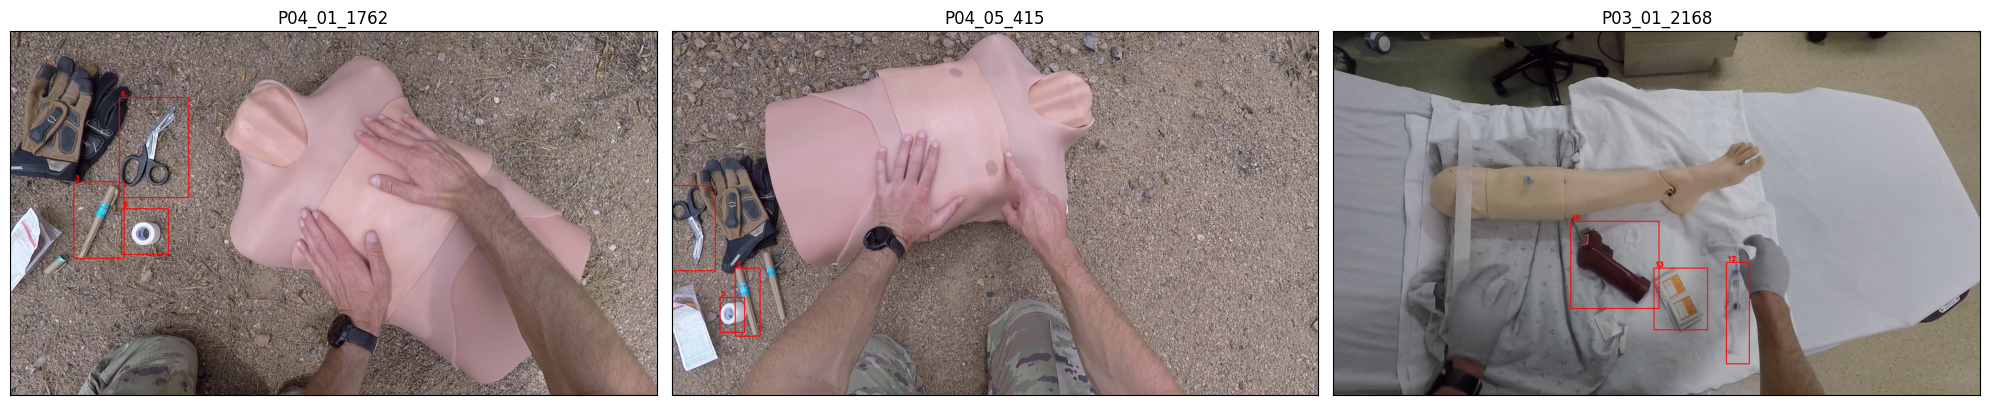

In [3]:
n_img = 3
example_img_pths = glob(os.path.join(img_pth, "*"))
fig, axs = plt.subplots(1, n_img, figsize=(20, 5))
for ax, i in zip(axs, range(n_img)):
    example_img_pth = example_img_pths[i]
    img_name = os.path.basename(example_img_pth).replace(".jpg", "")
    anno_name = img_name + ".txt"
    example_anno_pth = os.path.join(anno_pth, anno_name)
    img = cv2.cvtColor(cv2.imread(example_img_pth), cv2.COLOR_BGR2RGB)
    image_height, image_width = img.shape[0], img.shape[1]
    with open(example_anno_pth, "r") as f:
        lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        class_id = int(parts[0])
        x_center, y_center, w, h = map(float, parts[1:])
        # Convert normalized → pixel coordinates
        x_center *= image_width
        y_center *= image_height
        w *= image_width
        h *= image_height
        x_min = int(x_center - w / 2)
        y_min = int(y_center - h / 2)
        x_max = int(x_center + w / 2)
        y_max = int(y_center + h / 2)
        cv2.putText(
            img,
            str(class_id),
            (x_min + 4, y_min - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 0, 0),
            2,
            cv2.LINE_AA,
        )
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{img_name}")
plt.tight_layout()
plt.show()


Loop through each annotations and check if the annotations are empty and collect data at the same time

In [ ]:
anno_pth = (
    "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task3_tools/labels/train"
)
img_pth = (
    "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task3_tools/images/train"
)
img_pths = glob(os.path.join(img_pth, "*"))
n_classes = 17  # defined by the challenge
# create empty dictonary list
class_dict = {}
df_list = []
for img_pth in sorted(img_pths):
    img_name = os.path.basename(img_pth).replace(".jpg", "")
    anno_name = img_name + ".txt"
    query_anno_pth = os.path.join(anno_pth, anno_name)
    img = cv2.cvtColor(cv2.imread(img_pth), cv2.COLOR_BGR2RGB)
    image_height, image_width = img.shape[0], img.shape[1]
    video_id = "_".join(img_name.split("_")[:2])
    for i in range(n_classes):
        class_dict[str(i)] = 0
    with open(query_anno_pth, "r") as f:
        lines = f.readlines()
    if len(lines) == 0:
        print(f"No annotations for {img_name}")
        continue
    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            continue
        class_id = int(parts[0])
        class_dict[str(class_id)] += 1
    # cast value to list for Dataframe conversion
    class_dict = {k: [v] for k, v in class_dict.items()}
    output_dict = {
        "video_id": [video_id],
        "img_name": [img_name],
        "width": [image_width],
        "height": [image_height],
        **class_dict,
    }
    df = pd.DataFrame(output_dict)
    df_list.append(df)
    df = pd.concat(df_list, ignore_index=True)
    # df.to_csv("./outputs/trauma_thompson_task3_eda.csv", index=False)

Check if image resizing is require

In [ ]:
df = pd.read_csv("./outputs/trauma_thompson_task3_eda.csv")

print("Width range: ", df["width"].min(), df["width"].max())
print("Height range: ", df["height"].min(), df["height"].max())

Width range:  1920 1920
Height range:  1080 1080


---

# Distribution Plot

/tmp/ipykernel_3353914/1050642656.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bar_colors = [cm.get_cmap('tab20')(i) for i in range(n_classes)]


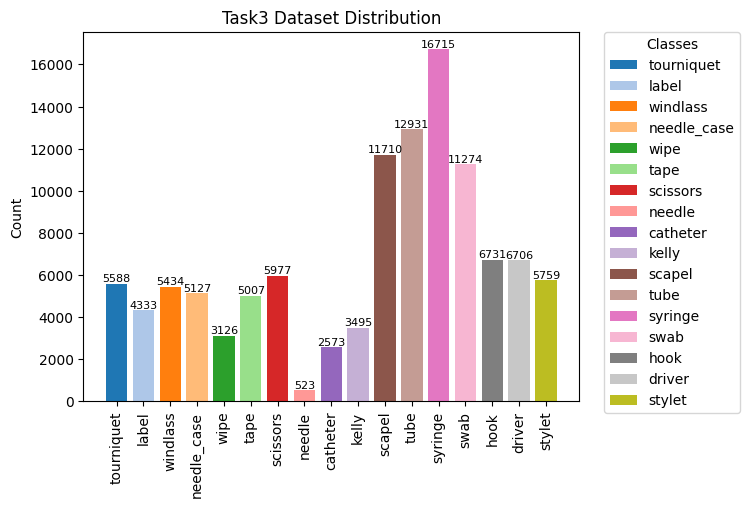

In [ ]:
# plot the distribution of the dataset
def plot_dataset_distribution(df, title="Task3 Dataset Distribution"):
    n_classes = 17
    id_to_cls = {
        0: "tourniquet",
        1: "label",
        2: "windlass",
        3: "needle_case",
        4: "wipe",
        5: "tape",
        6: "scissors",
        7: "needle",
        8: "catheter",
        9: "kelly",
        10: "scapel",
        11: "tube",
        12: "syringe",
        13: "swab",
        14: "hook",
        15: "driver",
        16: "stylet",
    }
    cls_count = [df[str(i)].sum().tolist() for i in range(n_classes)]
    cls_list = [id_to_cls[i] for i in range(n_classes)]

    fig, ax = plt.subplots()

    bar_colors = [cm.get_cmap("tab20")(i) for i in range(n_classes)]

    bars = ax.bar(cls_list, cls_count, label=cls_list, color=bar_colors)
    ax.bar_label(bars, label_type="edge", color="black", fontsize=8)
    ax.set_ylabel("Count")
    ax.set_title(title)
    ax.legend(
        title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0
    )
    plt.xticks(rotation=90)
    plt.show()


plot_dataset_distribution(df)

Initial idea was to split the dataset into train set and validation set according to video_id. <br>
Seems like some class are video id specific and therefore we cannot split the dataset based on video id.

In [ ]:
x = df["img_name"].to_list()
# literally multi hot encording of the classes
y = df[[f"{i}" for i in range(n_classes)]].to_numpy()

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
train_df = pd.DataFrame({"img_name": x_train})
train_df["split"] = "train"
val_df = pd.DataFrame({"img_name": x_val})
val_df["split"] = "val"
train_val_df = pd.concat([train_df, val_df], ignore_index=True)
# train_val_df.to_csv("./outputs/trauma_thompson_task3_dataset_split.csv", index=False)

/tmp/ipykernel_3353914/1050642656.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bar_colors = [cm.get_cmap('tab20')(i) for i in range(n_classes)]


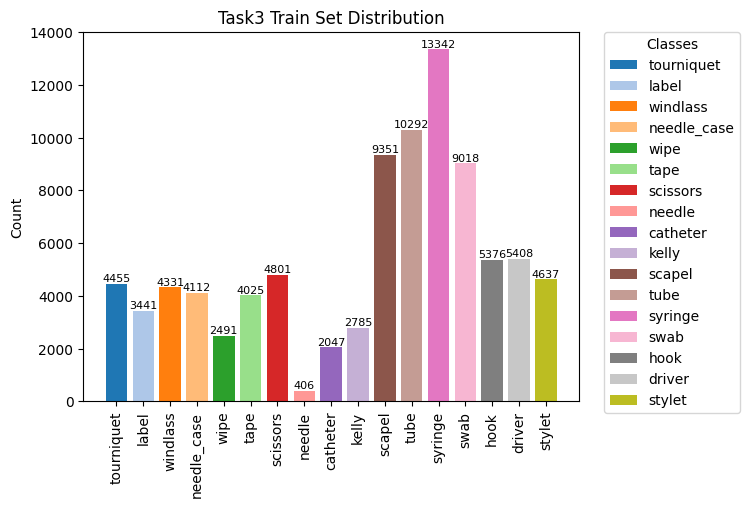

In [ ]:
merge_df = pd.merge(df, train_val_df, on="img_name", how="left")

plot_dataset_distribution(
    merge_df.query("split == 'train'"), title="Task3 Train Set Distribution"
)

/tmp/ipykernel_3353914/1050642656.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  bar_colors = [cm.get_cmap('tab20')(i) for i in range(n_classes)]


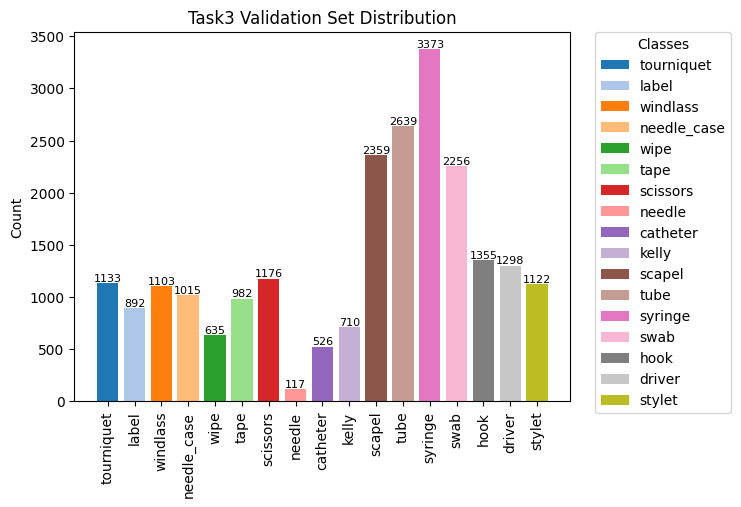

In [ ]:
plot_dataset_distribution(
    merge_df.query("split == 'val'"), title="Task3 Validation Set Distribution"
)

---

# Structure Data for Training

We will be structuring the training data into the ones that is similar to Ultralytics/ <br>
Since we already have the all the data in a "train" folder, we just nee do move the "validation" dataset <br>
to another folder. 

In [9]:
split_df = pd.read_csv("./outputs/trauma_thompson_task3_dataset_split.csv")

print("Training set size: ", len(split_df.query("split == 'train'")))
print("Validation set size: ", len(split_df.query("split == 'val'")))


Training set size:  28872
Validation set size:  7219


In [ ]:
import shutil

# original dataset
img_dir = (
    "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task3_tools/images/train"
)
anno_dir = (
    "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task3_tools/labels/train"
)
# validation dataset
val_img_dir = (
    "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task3_tools/images/val"
)
val_anno_dir = (
    "/home/kevinteng/Desktop/dataset/trauma_thompson_dataset/task3_tools/labels/val"
)

if not os.path.exists(val_img_dir):
    os.makedirs(val_img_dir)
if not os.path.exists(val_anno_dir):
    os.makedirs(val_anno_dir)
# only move the validation set'
for image_name in split_df.query("split == 'val'")["img_name"].to_list():
    try:
        shutil.move(
            os.path.join(img_dir, image_name + ".jpg"),
            os.path.join(val_img_dir, image_name + ".jpg"),
        )
    except Exception as e:
        print(f"Error moving {image_name}.jpg: {e}")
        pass
    try:
        shutil.move(
            os.path.join(anno_dir, image_name + ".txt"),
            os.path.join(val_anno_dir, image_name + ".txt"),
        )
    except Exception as e:
        print(f"Error moving {image_name}.txt: {e}")
        pass

